<h1 align="center"><b>Flight Booking Assistant</b></h1>


<p align="center">
  <b> Tried with Human in Loop, Time Travel (Forking Technique) and Long Term Memory using Trust Call Extractor </b>
</p>

In [1]:
import os
import warnings
from operator import add
from datetime import datetime
from typing import Any, List, Optional, Annotated

import requests
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from tabulate import tabulate

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from langchain_groq import ChatGroq

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, Literal
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from trustcall import create_extractor

warnings.filterwarnings('ignore')
load_dotenv(override=True)


True

In [2]:

os.environ["LANGCHAIN_PROJECT"] = "Ticket Booking"

Open weather 

In [3]:
class WeatherTool:
    def __init__(self):
        self.api_key = os.getenv("OPENWEATHER_API_KEY")
        self.base_url = "https://api.openweathermap.org/data/2.5/forecast"

    def get_weather(self, city: str, date: str) -> str:
        """
        Fetch weather forecast for a given city and date (within 8-day range).
        :param city: City name (str)
        :param date: Date string in 'YYYY-MM-DD' format
        :return: Weather description with temperature or error message
        """
        try:
            response = requests.get(
                self.base_url,
                params={"q": city, "appid": self.api_key, "units": "metric"}
            )
            response.raise_for_status()
            data = response.json()

            # Convert input date to datetime for comparison
            target_date = datetime.strptime(date, "%Y-%m-%d").date()

            # Check forecast list
            for entry in data["list"]:
                forecast_time = datetime.fromtimestamp(entry["dt"])
                if forecast_time.date() == target_date:
                    desc = entry["weather"][0]["description"].capitalize()
                    temp = entry["main"]["temp"]
                    return f"Weather in {city} on {date}: {desc}, {temp}°C"

            return f"No forecast available for {date}. Try another date within 5 days."

        except Exception as e:
            return f"Error fetching weather: {str(e)}"


Testing the Open WeatherTool

In [4]:
tool = WeatherTool()
city = "Delhi"
date = "2025-08-30"   

print(tool.get_weather(city, date))

Weather in Delhi on 2025-08-30: Overcast clouds, 29.21°C


Get Weather Node

In [5]:

def get_weather_suggestion(weatherinfo: str):
    
    weather_info= weatherinfo
    # LLM for suggestion
    llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.0)

    system_message = SystemMessage(
    content=(
        "You are a reliable flight booking assistant. "
        "Provide clear, practical guidance on flying in the given weather. "
        "Highlight safety, risks, delays, and precautions in **maximum 4 concise bullet points**, "
        "including the city and date of travel. "
        "Ensure suggestions are actionable, trustworthy, and easy to follow."
        )
    )

    human_message = HumanMessage(
        content=(
            f"Weather forecast from OpenWeather API: {weather_info}. "
            f"First provide the city and date of travel. "
            f"Then give safety guidance for flying under these conditions, "
            f"covering risks, delays, and practical precautions in short, clear sentences."
        )
    )

     
    
    messages = [
    system_message,
    human_message
    ]
    
    response = llm.invoke(messages)
    return response.content


Defining the Graph State

In [6]:

class FlightState(BaseModel):
    weather_info: Optional[str]=None
    safety_advice: Optional[str]=None
    user_confirmation: Optional[str]=None
    llm_output: Optional[str]=None
    City: Optional[str]=None
    Date: Optional[str]=None
    flight_name: Optional[str]=None
    destination: Optional[str]= None
    seat_preference: Optional[str] = "Any" # Window / Aisle / Middle
    departure: Optional[str]= None    

    passenger_name: Optional[str] = None
    Gender: Optional[str] = "Male"
    Age : Optional[int]= None
    passport_number: Optional[str] = None          
    contact_number: Optional[str] =  None
    Chat_history:Optional[str] = None
    messages: Annotated[List[Any], add]
    


Human in Loop Concept

In [7]:
def Human_confirmation(state: FlightState)->Command[Literal["final_confirmation"]]:
    print("Safety advice to user:\n", state.safety_advice)
    is_approved = interrupt({
        "question": "Do you want to confirm the booking?",
        "confirmation": None
    })

     # Normalize responses (yes, ok, book now → True | no, cancel → False)
    normalized = str(is_approved).strip().lower()
    confirm_words = {"yes", "ok", "book now", "confirm"}
    reject_words = {"no", "cancel", "not now"}

    if normalized in confirm_words:
        return Command(goto="get_details", update={"user_confirmation": "yes"})
    elif normalized in reject_words:
        return Command(goto="final_confirmation", update={"user_confirmation": "no"})
    else:
        # fallback → ask again
        return interrupt({"question": "Sorry, I didn’t get that. Confirm booking? (yes/no)"})

Get Details Node (Hard coded for simplicity)

In [8]:
def get_details( flight: FlightState):
    flight.passenger_name = "Abhiram"
    flight.Age = 27
    flight.Gender = "Male"
    flight.contact_number = "989776786"
    
    flight.destination = "London"
    flight.flight_name = "Air India"
    flight.seat_preference = "Window"
    flight.departure = "10AM"
    
    return flight

Ticket Generating Node

In [9]:
llm = ChatGroq(model="gemma2-9b-it")

def final_llm_response(state: FlightState):
    user_conf = state.user_confirmation.strip().lower()

    if user_conf:
        prompt = f"""
You are a helpful flight ticket booking assistant. 
The user has replied: "{user_conf}"

If the reply is exactly "Yes":
- Output ONLY the dummy flight ticket in the exact format below.
- Do NOT explain, do NOT add extra text, do NOT repeat instructions.

Ticket format:
--------------------------------------------------
                ✈ Flight Ticket ✈
--------------------------------------------------
 Passenger Name : {state.passenger_name}
 Age            : {state.Age}
 Gender         : {state.Gender}
 Contact Number : {state.contact_number}
--------------------------------------------------
 Airline        : {state.flight_name}
 Departure      : {state.departure}
 From           : {state.City}
 To             : {state.destination}
 Date           : {state.Date}
 Seat Preference: {state.seat_preference}
--------------------------------------------------
   Wishing you a safe and pleasant journey! ✈
--------------------------------------------------

If the reply is exactly "No":
Output only:  
"Thank you for using! See you again."
"""

    
    # Call LLM
    result = llm.invoke(prompt)

    # force string
    state.llm_output = str(result)  

    # OR, if result has .content (LLM message object)
    state.llm_output = result.content if hasattr(result, "content") else str(result)

    return state



### Long Term memory using Trust call
Writing into memory 

In [10]:
# Memory stores
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

# ---------------- SCHEMA ----------------
class FlightRecord(BaseModel):
    """Schema for a single flight record in the user's booking history."""
    date: str = Field(description="Flight date in YYYY-MM-DD format")
    airline: str = Field(description="Airline name")
    origin: str = Field(description="Departure city")
    destination: str = Field(description="Arrival city")
    seat: str = Field(description="Seat preference")
    departure_time: str = Field(description="Scheduled departure time")
    summary: str = Field(description="Concise human-readable ticket summary")


class UserProfile(BaseModel):
    """Complete user profile containing name and past flight history."""
    user_name: str = Field(description="The user's preferred name")
    flight_history: List[FlightRecord] = Field(
        default_factory=list,
        description="List of all past flight tickets with structured details"
    )

# ---------------- LLM + Extractor ----------------
model = ChatGroq(model="llama-3.1-8b-instant", temperature=0.0)

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)


MODEL_SYSTEM_MESSAGE = """You are a flight booking assistant. 
Greet the user briefly, and then present their past flight history in clear bullet points using the memory provided. 
Do not add any explanations or extra information. 
Here is the memory (it may be empty): {memory}"""

TRUSTCALL_INSTRUCTION = """Create or update the user profile memory (JSON doc) to incorporate information from the following conversation.
The memory should follow this schema:
- user_name: The user's preferred name
- flight_history: A list of FlightRecord objects, where each record contains:
  (date, airline, origin, destination, seat, departure_time, summary)

Rules:
- Always preserve existing memory.
- If a new flight is mentioned, append it to flight_history as a new record.
- If a flight with the same date already exists, update its details instead of duplicating.
- Keep all data consistent and structured."""

# ---------------- WRITE MEMORY ----------------
def write_memory(state: FlightState , config: RunnableConfig, store: BaseStore):
    """Reflect on the booking conversation and save memory to the store."""

    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)

    # Load existing memory (already JSON-like dict if present)
    existing_memory = store.get(namespace, "user_profile")
    existing_profile = existing_memory.value if existing_memory else None

    # Run extractor with messages + existing profile
    result = trustcall_extractor.invoke(
        {
            "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state.messages,
            "existing": existing_profile,
        }
    )

    # Unpack the UserProfile returned by trustcall_extractor
    resp = result["responses"][0]

    if isinstance(resp, UserProfile):
        updated_profile = resp
    else:
        updated_profile = UserProfile(**resp)

    if existing_profile:
        raw_profile = existing_profile.get("UserProfile", existing_profile)

        if isinstance(raw_profile, UserProfile):
            old_profile = raw_profile
        else:
            old_profile = UserProfile(**raw_profile)

        # merge without duplicates by date
        existing_flights = {rec.date: rec for rec in old_profile.flight_history}
        for rec in updated_profile.flight_history:
            existing_flights[rec.date] = rec
        updated_profile.flight_history = list(existing_flights.values())

    # Save JSON back into store
    store.put(namespace, "user_profile", {"UserProfile": updated_profile.model_dump()})

    return state

Taking History from Memory

In [11]:
def call_memory(state: FlightState, config: RunnableConfig, store: BaseStore):
    """Load flight booking history from memory and return it as formatted output."""

    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_profile")

    memory_value = getattr(existing_memory, "value", existing_memory)

    if memory_value:
        if isinstance(memory_value, dict):
            history_list = [memory_value]
        elif isinstance(memory_value, list):
            history_list = memory_value
        else:
            history_list = []

        table_data = [
            [i+1,
             entry.get("passenger_name", "Unknown"),
             entry.get("Date", "Unknown"),
             entry.get("departure", "Unknown"),
             entry.get("destination", "Unknown"),
             entry.get("flight_name", "Unknown"),]
            for i, entry in enumerate(history_list)
        ]
        headers = ["#","Passenger", "Date", "Departure", "Destination", "Flight"]
        formatted_history = tabulate(table_data, headers=headers, tablefmt="pretty")
    else:
        formatted_history = "No past flight history found."

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_history)

    llm_output = state.llm_output
    if not llm_output:
        llm_output = []
    elif isinstance(llm_output, str):
        llm_output = [HumanMessage(content=llm_output)]
    elif not isinstance(llm_output, list):
        llm_output = [llm_output]

    response = llm.invoke([SystemMessage(content=system_msg)] + llm_output)

    return {"Chat_history": response.content}


Defining the Weather and Suggetion Nodes

In [12]:
def Weather_prediction(state: FlightState):
    date=state.Date 
    city=state.City
    weather=WeatherTool()

    state.weather_info= weather.get_weather(city, date)
    return state

def Suggetion(state: FlightState):
    weather_info=state.weather_info
    state.safety_advice= get_weather_suggestion(weather_info)
    return state


Buuilding Graph

In [13]:
def history_condition(state):
    user_input = input("\n🤔 Do you want to see your flight history? (yes/no) ")
    if user_input.lower() == "yes":
        return "call_memory"
    else:
        return "end"


graph = StateGraph(FlightState)

graph.add_node("Weather_prediction",Weather_prediction)
graph.add_node("Suggetion",Suggetion)
graph.add_node("Human_confirmation", Human_confirmation)
graph.add_node("final_confirmation",final_llm_response )
graph.add_node("get_details", get_details)
graph.add_node("write_memory", write_memory)
graph.add_node("call_memory", call_memory)



graph.add_edge(START, "Weather_prediction")
graph.add_edge("Weather_prediction", "Suggetion")
graph.add_edge("Suggetion", "Human_confirmation")
graph.add_edge("Human_confirmation", "get_details")
graph.add_edge("get_details","final_confirmation")
graph.add_edge("final_confirmation","write_memory")

graph.add_conditional_edges(
    "write_memory",
    history_condition,   # function returning node name
    {
        "call_memory": "call_memory",
        "end": END,
    },
)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph_final = graph.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory
)


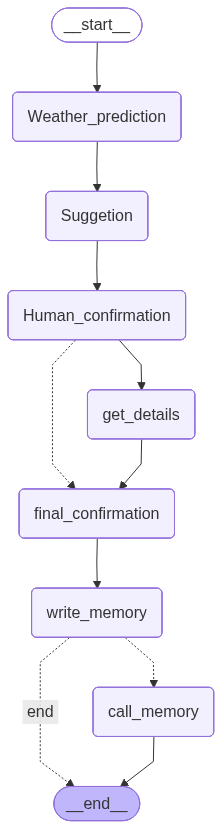

In [14]:
graph_final

Invoking with a thread_id and user_id

In [15]:
result = await graph_final.ainvoke(
    {"City": "Bangalore", "Date": "2025-08-29"},
    config={"configurable": {"thread_id": "1", "user_id": "user1"}}
)
print(result)


Safety advice to user:
 **City:** Bangalore
**Date of Travel:** 2025-08-29

**Safety Guidance for Flying in Overcast Conditions:**

* **Risks:** Overcast skies can lead to reduced visibility during takeoff and landing, increasing the risk of accidents. However, this is unlikely in well-maintained airports like Bangalore's Kempegowda International Airport.
* **Delays:** Overcast conditions may cause minor delays due to reduced visibility, but this is usually manageable with modern air traffic control systems.
* **Precautions:** Passengers should arrive at the airport with sufficient time to account for any potential delays. Pilots will take necessary precautions to ensure safe takeoff and landing procedures.
* **Pre-flight checks:** Airlines will conduct thorough pre-flight checks to ensure the aircraft is airworthy and equipped for safe flight operations in overcast conditions.
{'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 25.61°C', 'safety_advice': "**City:** 

Interrupts because of Human in loop: need to resume graph flow

In [16]:
result = await graph_final.ainvoke(
    Command(resume="yes"),
    config={"configurable": {"thread_id": "1", "user_id": "user1"}}
)
print(result)

Safety advice to user:
 **City:** Bangalore
**Date of Travel:** 2025-08-29

**Safety Guidance for Flying in Overcast Conditions:**

* **Risks:** Overcast skies can lead to reduced visibility during takeoff and landing, increasing the risk of accidents. However, this is unlikely in well-maintained airports like Bangalore's Kempegowda International Airport.
* **Delays:** Overcast conditions may cause minor delays due to reduced visibility, but this is usually manageable with modern air traffic control systems.
* **Precautions:** Passengers should arrive at the airport with sufficient time to account for any potential delays. Pilots will take necessary precautions to ensure safe takeoff and landing procedures.
* **Pre-flight checks:** Airlines will conduct thorough pre-flight checks to ensure the aircraft is airworthy and equipped for safe flight operations in overcast conditions.
{'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 25.61°C', 'safety_advice': "**City:** 

In [17]:
ticket = result['llm_output']
print(ticket)

--------------------------------------------------
                ✈ Flight Ticket ✈
--------------------------------------------------
 Passenger Name : Abhiram
 Age            : 27
 Gender         : Male
 Contact Number : 989776786
--------------------------------------------------
 Airline        : Air India
 Departure      : 10AM
 From           : Bangalore
 To             : London
 Date           : 2025-08-29
 Seat Preference: Window
--------------------------------------------------
   Wishing you a safe and pleasant journey! ✈
-------------------------------------------------- 




In [18]:
Chat_history = result['Chat_history']
print(Chat_history)

Hello! Here's your past flight history:

* Passenger: Abhiram
* Date: 2025-08-29
* Departure: Bangalore
* Destination: London
* Flight:  Air India 





In [19]:
thread = {"configurable": {"thread_id": "1","user_id": "user1"}}
all_states = [s for s in graph_final.get_state_history(thread)]

In [20]:
len(all_states)

9

In [21]:
all_states

[StateSnapshot(values={'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 25.61°C', 'safety_advice': "**City:** Bangalore\n**Date of Travel:** 2025-08-29\n\n**Safety Guidance for Flying in Overcast Conditions:**\n\n* **Risks:** Overcast skies can lead to reduced visibility during takeoff and landing, increasing the risk of accidents. However, this is unlikely in well-maintained airports like Bangalore's Kempegowda International Airport.\n* **Delays:** Overcast conditions may cause minor delays due to reduced visibility, but this is usually manageable with modern air traffic control systems.\n* **Precautions:** Passengers should arrive at the airport with sufficient time to account for any potential delays. Pilots will take necessary precautions to ensure safe takeoff and landing procedures.\n* **Pre-flight checks:** Airlines will conduct thorough pre-flight checks to ensure the aircraft is airworthy and equipped for safe flight operations in overcast conditions.", 'u

### Time Travel
Taking the checkpoint_id of the node to where we need to Time travel

In [22]:
# Getting the checkpoint id of get details node
for snap in all_states:
    for task in snap.tasks:
        if task.name == "final_confirmation":
            print(snap.config['configurable']['checkpoint_id'])


1f084997-7020-63db-8004-246723a05acd


In [26]:
graph_final.update_state(
    {"configurable": {
        "thread_id": "1",
        "user_id": "user1",
        "checkpoint_id": "1f084997-7020-63db-8004-246723a05acd",
        "checkpoint_ns": ""
    }},
    {"flight_name": "Emirates"}
)


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084998-4969-6c54-8005-3c20e67807b0'}}

In [29]:
list(graph_final.get_state_history({"configurable": {
        "thread_id": "1",
        "user_id":"user1", 
        "checkpoint_id": "1f084998-4969-6c54-8005-3c20e67807b0",
        "checkpoint_ns": ""
    }}))

[StateSnapshot(values={'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 25.61°C', 'safety_advice': "**City:** Bangalore\n**Date of Travel:** 2025-08-29\n\n**Safety Guidance for Flying in Overcast Conditions:**\n\n* **Risks:** Overcast skies can lead to reduced visibility during takeoff and landing, increasing the risk of accidents. However, this is unlikely in well-maintained airports like Bangalore's Kempegowda International Airport.\n* **Delays:** Overcast conditions may cause minor delays due to reduced visibility, but this is usually manageable with modern air traffic control systems.\n* **Precautions:** Passengers should arrive at the airport with sufficient time to account for any potential delays. Pilots will take necessary precautions to ensure safe takeoff and landing procedures.\n* **Pre-flight checks:** Airlines will conduct thorough pre-flight checks to ensure the aircraft is airworthy and equipped for safe flight operations in overcast conditions.", 'u

In [30]:
graph_final.invoke(None, {"configurable": {
        "thread_id": "1",
        "user_id":"user1", 
        "checkpoint_id": "1f084998-4969-6c54-8005-3c20e67807b0",
        "checkpoint_ns": ""
    }})


{'weather_info': 'Weather in Bangalore on 2025-08-29: Overcast clouds, 25.61°C',
 'safety_advice': "**City:** Bangalore\n**Date of Travel:** 2025-08-29\n\n**Safety Guidance for Flying in Overcast Conditions:**\n\n* **Risks:** Overcast skies can lead to reduced visibility during takeoff and landing, increasing the risk of accidents. However, this is unlikely in well-maintained airports like Bangalore's Kempegowda International Airport.\n* **Delays:** Overcast conditions may cause minor delays due to reduced visibility, but this is usually manageable with modern air traffic control systems.\n* **Precautions:** Passengers should arrive at the airport with sufficient time to account for any potential delays. Pilots will take necessary precautions to ensure safe takeoff and landing procedures.\n* **Pre-flight checks:** Airlines will conduct thorough pre-flight checks to ensure the aircraft is airworthy and equipped for safe flight operations in overcast conditions.",
 'user_confirmation': '

With Another thread_id

In [31]:
result = await graph_final.ainvoke(
    {"City": "Delhi", "Date": "2025-08-30"},
    config={"configurable": {"thread_id": "2", "user_id": "user2"}}
)
print(result)


Safety advice to user:
 **City:** Delhi
**Date of Travel:** 2025-08-30

**Safety Guidance for Flying in Overcast Conditions:**

* **Risks:** Overcast conditions may lead to reduced visibility during takeoff and landing, increasing the risk of accidents. **Precaution:** Check with the airline for any specific weather-related restrictions or advisories before your flight.
* **Delays:** Overcast conditions can cause flight delays due to reduced visibility and potential turbulence. **Precaution:** Plan to arrive at the airport with plenty of time to spare, and stay informed about any flight updates or changes.
* **Safety Precautions:** In case of turbulence, seatbelts must be worn at all times. **Action:** Listen to the flight attendants' instructions and follow their guidance during turbulence.
* **Pre-Flight Precautions:** Ensure you have all necessary documents and check-in online to minimize delays. **Action:** Double-check your flight itinerary and travel documents before heading to t

In [32]:
result = await graph_final.ainvoke(
    Command(resume="yes"),
    config={"configurable": {"thread_id": "2", "user_id": "user2"}}
)
print(result)

Safety advice to user:
 **City:** Delhi
**Date of Travel:** 2025-08-30

**Safety Guidance for Flying in Overcast Conditions:**

* **Risks:** Overcast conditions may lead to reduced visibility during takeoff and landing, increasing the risk of accidents. **Precaution:** Check with the airline for any specific weather-related restrictions or advisories before your flight.
* **Delays:** Overcast conditions can cause flight delays due to reduced visibility and potential turbulence. **Precaution:** Plan to arrive at the airport with plenty of time to spare, and stay informed about any flight updates or changes.
* **Safety Precautions:** In case of turbulence, seatbelts must be worn at all times. **Action:** Listen to the flight attendants' instructions and follow their guidance during turbulence.
* **Pre-Flight Precautions:** Ensure you have all necessary documents and check-in online to minimize delays. **Action:** Double-check your flight itinerary and travel documents before heading to t

In [33]:
new_ticket = result['llm_output']
print(new_ticket)

--------------------------------------------------
                ✈ Flight Ticket ✈
--------------------------------------------------
 Passenger Name : Abhiram
 Age            : 27
 Gender         : Male
 Contact Number : 989776786
--------------------------------------------------
 Airline        : Air India
 Departure      : 10AM
 From           : Delhi
 To             : London
 Date           : 2025-08-30
 Seat Preference: Window
--------------------------------------------------
   Wishing you a safe and pleasant journey! ✈
-------------------------------------------------- 




In [34]:
# Getting the checkpoint id of get details node
for snap in all_states:
    for task in snap.tasks:
        if task.name == "final_confirmation":
            print(snap.config['configurable']['checkpoint_id'])

1f084997-7020-63db-8004-246723a05acd


In [35]:
graph_final.update_state(
    {"configurable": {
        "thread_id": "2",
        "user_id": "user2",
        "checkpoint_id": "1f084997-7020-63db-8004-246723a05acd",
        "checkpoint_ns": ""
    }},
    {"flight_name": "Indigo"}
)


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08499f-5843-66af-8000-6da55b7067d6'}}

In [36]:
list(graph_final.get_state_history({"configurable": {
        "thread_id": "2",
        "user_id":"user2", 
        "checkpoint_id": "1f08499f-5843-66af-8000-6da55b7067d6",
        "checkpoint_ns": ""
    }}))

[StateSnapshot(values={'flight_name': 'Indigo', 'messages': []}, next=('Weather_prediction',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f08499f-5843-66af-8000-6da55b7067d6'}}, metadata={'source': 'update', 'step': 0, 'parents': {}, 'user_id': 'user2'}, created_at='2025-08-29T05:35:23.243076+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f084997-7020-63db-8004-246723a05acd'}}, tasks=(PregelTask(id='8ba2eeee-8184-d40f-c825-edcafaa49059', name='Weather_prediction', path=('__pregel_pull', 'Weather_prediction'), error=None, interrupts=(), state=None, result=None),), interrupts=())]

#################################################

In [37]:
graph_final.invoke(None, {"configurable": {
        "thread_id": "2",
        "user_id":"user2", 
        "checkpoint_id": "1f08499f-5843-66af-8000-6da55b7067d6",
        "checkpoint_ns": ""
    }})

Safety advice to user:
 Unfortunately, I don't have the city and date of travel information. However, I can provide general guidance on flying in various weather conditions.

Assuming you're planning to travel on a specific date and to a specific city, please provide the following information:

- City
- Date of travel (in the format: DD/MM/YYYY)

Once I have this information, I can provide you with tailored safety guidance for flying under the given weather conditions.

However, I can provide general guidance on flying in various weather conditions:

**General Safety Guidance for Flying:**

- **Thunderstorms:** Avoid flying during thunderstorms, as they can cause turbulence, lightning strikes, and strong winds. If you must fly, choose a flight that avoids the storm's path.
- **Heavy Rain or Fog:** Delays are common in heavy rain or fog, as visibility is reduced, and runways may be slippery. Be prepared for potential delays and check with your airline for updates.
- **Strong Winds:** Tu

{'weather_info': 'Error fetching weather: 400 Client Error: Bad Request for url: https://api.openweathermap.org/data/2.5/forecast?appid=43464d16a0703c5d618c358c158b1e10&units=metric',
 'safety_advice': "Unfortunately, I don't have the city and date of travel information. However, I can provide general guidance on flying in various weather conditions.\n\nAssuming you're planning to travel on a specific date and to a specific city, please provide the following information:\n\n- City\n- Date of travel (in the format: DD/MM/YYYY)\n\nOnce I have this information, I can provide you with tailored safety guidance for flying under the given weather conditions.\n\nHowever, I can provide general guidance on flying in various weather conditions:\n\n**General Safety Guidance for Flying:**\n\n- **Thunderstorms:** Avoid flying during thunderstorms, as they can cause turbulence, lightning strikes, and strong winds. If you must fly, choose a flight that avoids the storm's path.\n- **Heavy Rain or Fog:*